# TabNet

* 公式：https://github.com/dreamquark-ai/tabnet
* カテゴリ変数についてはlabel embeddingが必要
* アルゴリズム解説記事　　
https://qiita.com/takotatsu5141/items/2e7c07c9734aa6f9181c

<a href="https://colab.research.google.com/github/fuyu-quant/Data_Science/blob/main/Tabel_Data/Regression%26Classification/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 692 kB/s 


In [ ]:
# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

import pandas as pd
import torch
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
data = fetch_covtype()
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.25,  random_state = 1)

In [ ]:
y_test

array([2, 1, 6, ..., 3, 2, 2], dtype=int32)

## TabNetのハイパーパラメータ
* https://github.com/dreamquark-ai/tabnet/#model-parameters

In [ ]:
tabnet_params = dict(n_d=8, 
                     n_a=8, 
                     n_steps=3, 
                     gamma=1.3,
                     n_independent=2, 
                     n_shared=2,
                     seed=3655, 
                     lambda_sparse=1e-3, 
                     optimizer_fn=torch.optim.Adam, 
                     optimizer_params=dict(lr=2e-2),
                     mask_type="entmax",
                     scheduler_params=dict(mode="min",
                                           patience=5,
                                           min_lr=1e-5,
                                           factor=0.9,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10,
                     device_name = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    )

## TabNetの事前学習

In [ ]:
pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(X_train,
               eval_set=[X_test],
               pretraining_ratio=0.8,
               max_epochs=10,
               patience=20,
               batch_size=512,
               virtual_batch_size=128,
               num_workers=1, 
               drop_last=True,
               )

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.26561 | val_0_unsup_loss_numpy: 19.72279930114746|  0:00:36s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_unsup_loss_numpy = 3.726900100708008


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## TabNetの学習

In [ ]:
tab_clf = TabNetClassifier(**tabnet_params)


tab_clf.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            max_epochs=30,
            patience=1000,
            eval_metric={'accuracy'}, # 'auc', 'accuracy', 'balanced_accuracy', 'logloss', 'mae', 'mse', 'rmsle', 'unsup_loss', 'unsup_loss_numpy', 'rmse'
            batch_size=512,
            virtual_batch_size=128,
            num_workers=1, 
            drop_last=False,
            from_unsupervised=pretrainer   # 事前学習モデルを使う場合
            )

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.66534 | val_0_accuracy: 0.75653 |  0:00:29s
epoch 10 | loss: 0.42449 | val_0_accuracy: 0.84247 |  0:05:19s
epoch 20 | loss: 0.39787 | val_0_accuracy: 0.85785 |  0:10:09s
Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_accuracy = 0.86332


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


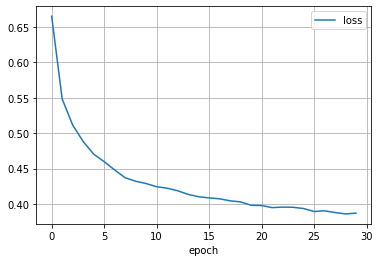

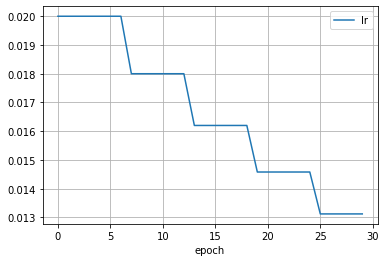

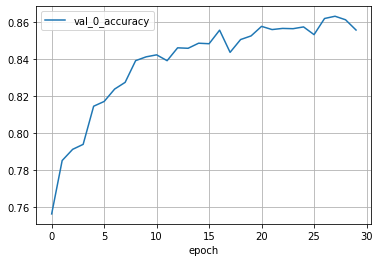

In [ ]:
for param in ['loss', 'lr', 'val_0_accuracy']:
    plt.plot(tab_clf.history[param], label=param)
    plt.xlabel('epoch')
    plt.grid()
    plt.legend()
    plt.show()

## TabNetの予測

In [ ]:
y_pred = tab_clf.predict(X_test)
y_pred

array([2, 1, 6, ..., 3, 2, 2], dtype=int32)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.8633212394924717


## 特徴量重要度の出力

Text(0.5, 1.0, 'feature_importance')

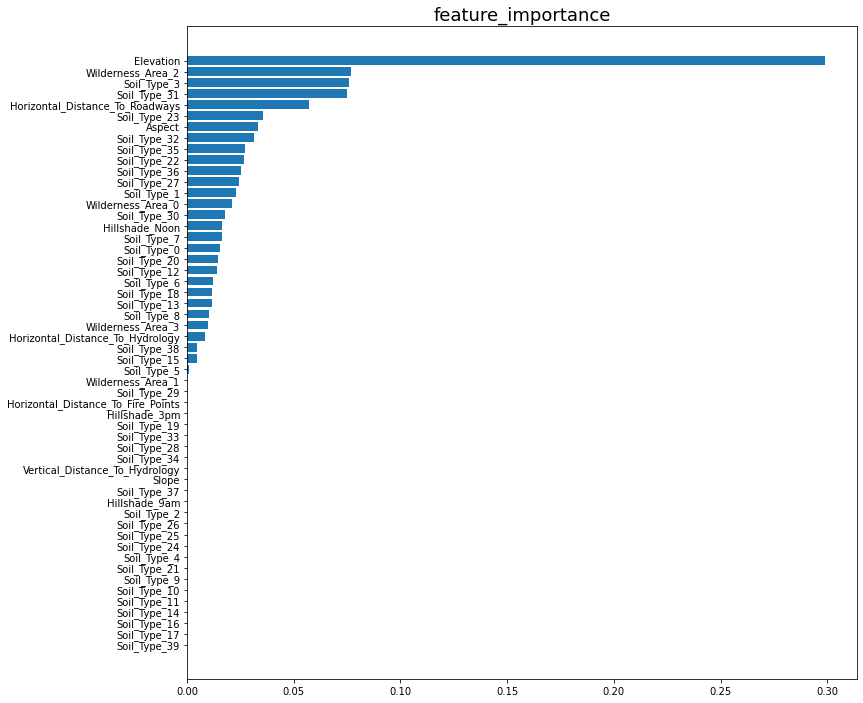

In [ ]:
feat_imp = pd.DataFrame(tab_clf.feature_importances_, index=data.feature_names)
feature_importance = feat_imp.copy()

feature_importance["imp_mean"] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values("imp_mean")

plt.figure(figsize=(12, 12))
plt.barh(feature_importance.index.values, feature_importance["imp_mean"])
plt.title("feature_importance", fontsize=18)

## maskの可視化

In [ ]:
explain_matrix, masks = tab_clf.explain(X_test)

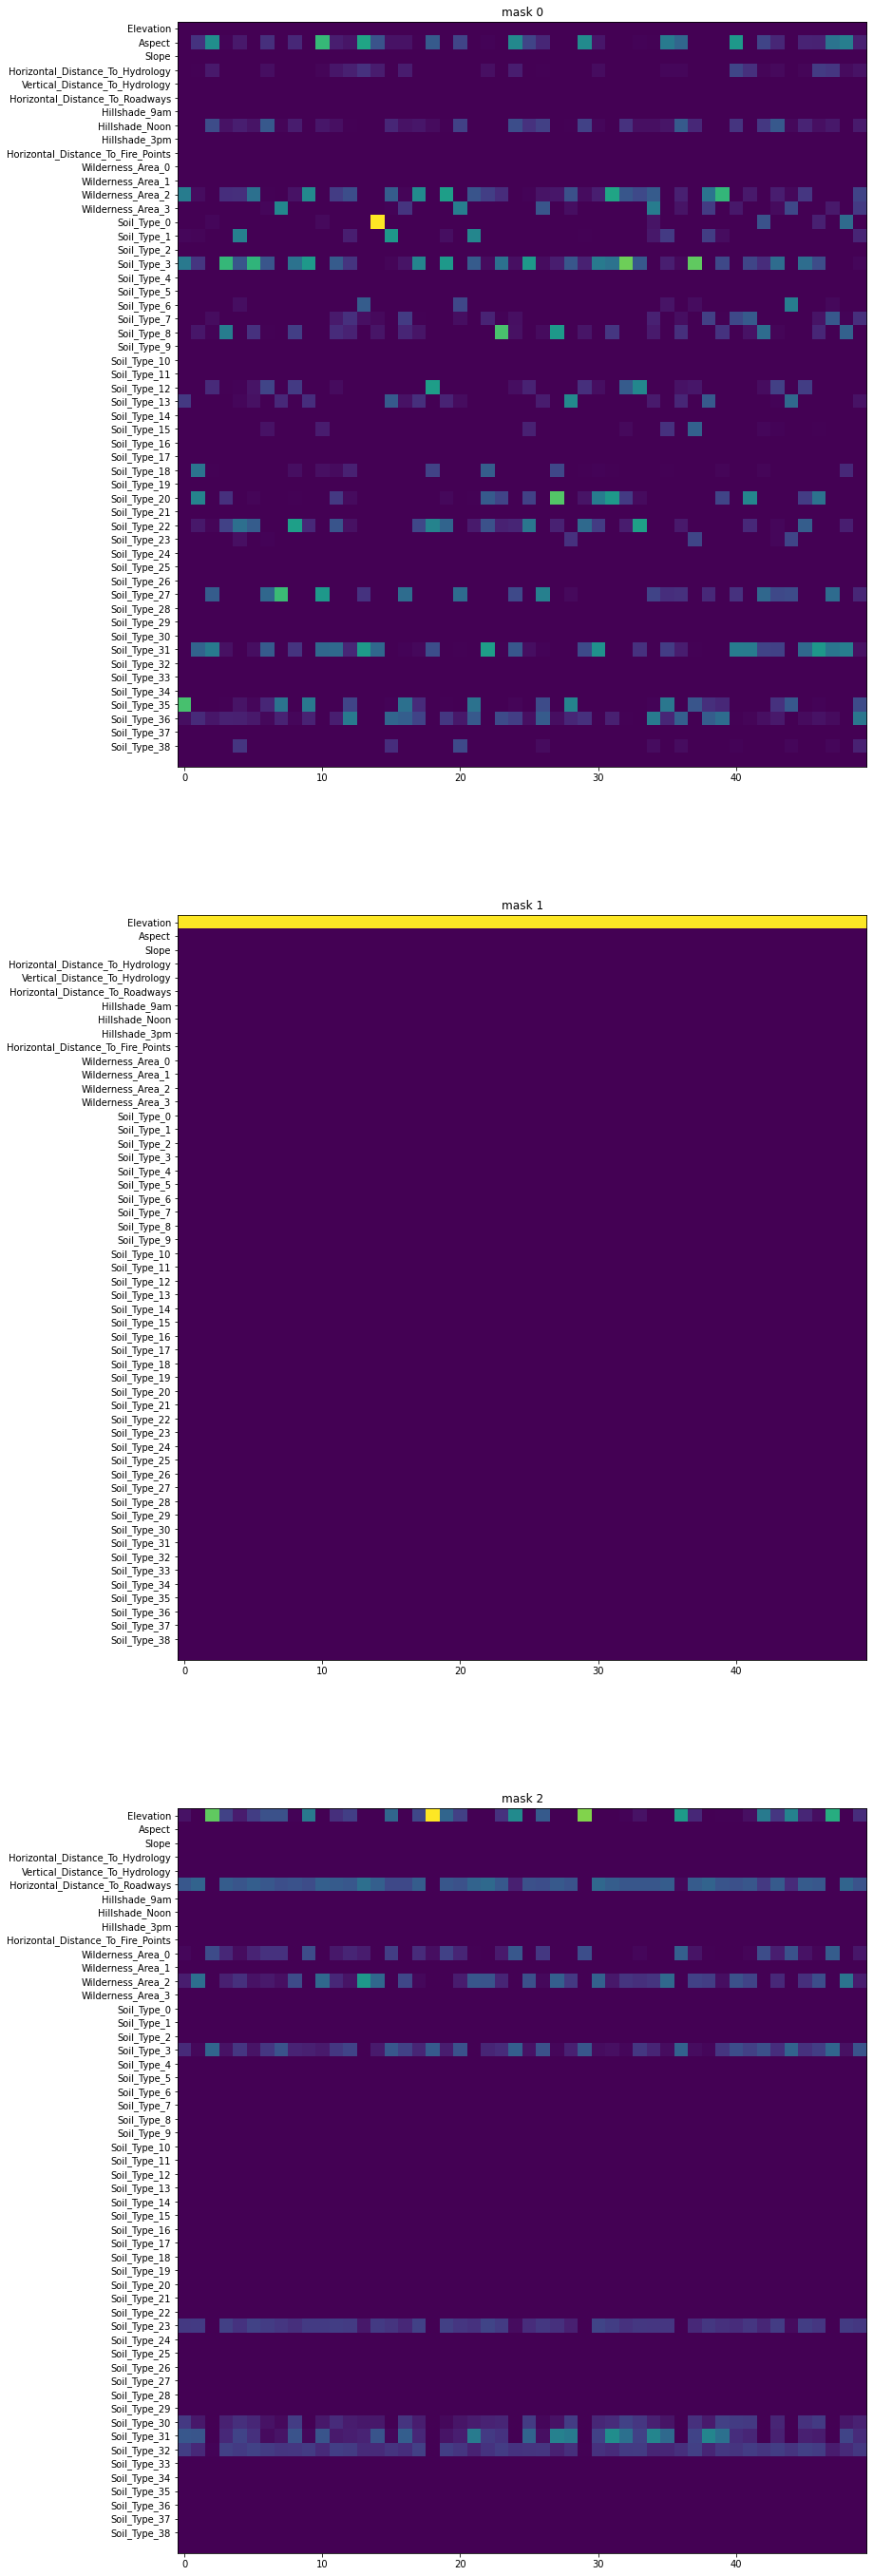

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 7*7))

for i in range(3):
    axs[i].imshow(masks[i][:50].T)
    axs[i].set_title(f"mask {i}")
    axs[i].set_yticks(range(len(data.feature_names[:-1])))
    axs[i].set_yticklabels(list(data.feature_names[:-1]))